In [ ]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
# Mount to Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Define Project Folder
FOLDERNAME = 'Colab\ Notebooks/MATSCI176/Final\ Project'
%cd drive/MyDrive/$FOLDERNAME

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/MATSCI176/Final Project


In [ ]:
# Data preprocessing for Nasa battery datasets
%run convert_nasa_dataset_discharge.py

In [ ]:
# Data Pre-processing

# Load dataset
file_name = "nasa_batteries_processed/data.csv"
absolute_path = os.path.abspath(file_name)  # Combine folder name and file name to create the full file path
df = pd.read_csv(absolute_path)

# Only include a subset of battery data that met specific reliability criteria
battery_id = [5, 6, 7, 18, 25, 29, 31, 34, 36, 45, 46, 47, 48, 54, 55, 56]

value_map = {5: 2, 6: 2, 7: 2, 18: 2, 25: 4, 29: 4, 31: 1.5, 34: 4, 36: 2, 45: 1, 46: 1, 47: 1, 48: 1, 54: 2, 55: 2, 56: 2}
df["load_current"] = df["battery_id"].map(value_map)

# Drop rows where 'SOH' has a zero value
df = df[df['soh'] != 0]

# Drop rows where 'column_name' is equal to a specific value
#df = df[df['cycle_id'] != 0]

# Assuming your dataframe is sorted by 'cycle_id' or any relevant column
df['prev_soh'] = df['soh'].shift(1)  # Get the previous SOH value
df['next_soh'] = df['soh'].shift(-1)  # Get the next SOH value

# Calculate percentage differences
df['prev_diff'] = abs(df['soh'] - df['prev_soh'])
df['next_diff'] = abs(df['soh'] - df['next_soh'])

# Add a check for the first row (compare the first row with the second)
df['first_row_diff'] = abs(df['soh'] - df['next_soh'])
df.loc[0, 'prev_diff'] = df.loc[0, 'first_row_diff']  # For the first row, set the previous difference to compare with the second

# Filter out rows where the SOH difference exceeds 10% in the previous or next row
df_filtered = df[(df['prev_diff'] <= 10) & (df['next_diff'] <= 10)]

# Drop the temporary columns used for calculation
df_filtered.drop(columns=['prev_soh', 'next_soh', 'prev_diff', 'next_diff', 'first_row_diff'], inplace=True)

# Training cycles
n_cycles = 40

<ipython-input-50-a09cf66d5c80>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.drop(columns=['prev_soh', 'next_soh', 'prev_diff', 'next_diff', 'first_row_diff'], inplace=True)


In [ ]:
# Data Pre-processing -> Normalization

# Normalize SOH (optional)
scaler = MinMaxScaler()
df_filtered['SOH_scaled'] = scaler.fit_transform(df_filtered[['soh']])

# Train-Test Split Function
def prepare_data(df, battery_id):
    battery_data = df[df['battery_id'] == battery_id].sort_values(by="cycle_id")
    train = battery_data[battery_data["cycle_id"] <= n_cycles]
    test = battery_data[battery_data["cycle_id"] > n_cycles]
    return train, test

# Apply to all batteries
train_list, test_list = [], []
for b in battery_id:
    train, test = prepare_data(df_filtered, b)
    train_list.append(train)
    test_list.append(test)

train_df = pd.concat(train_list)
test_df = pd.concat(test_list)

<ipython-input-5-1531a34d3b35>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['SOH_scaled'] = scaler.fit_transform(df_filtered[['soh']])


In [ ]:
# Feature Selection
features = ["cycle_id"]  # You can add more time-based features
X_train, y_train = train_df[features], train_df["SOH_scaled"]
X_test, y_test = test_df[features], test_df["SOH_scaled"]

In [ ]:
# XGBoost Model -> calculate MAE for entire dataset
# Use only cycle_id as feature for training

# Train XGBoost Model with best hyperparameters
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.01,
    max_depth=3,
    colsample_bytree=0.7,
    subsample=0.7,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Predict
y_pred = xgb_model.predict(X_test)

# Evaluate Performance
mae = mean_absolute_error(y_test, y_pred)
print(f"XGBoost MAE (single feature): {mae}")

XGBoost MAE (single feature): 0.10624439054066982


In [ ]:
# XGBoost Model -> calculate MAE for each battery
# Use only cycle_id as feature for training

# Initialize a dictionary to store MAE per battery
single_mae_xgb_per_battery = {}

for b in battery_id:
    # Extract test data for this battery
    test_battery_df = test_df[test_df["battery_id"] == b]
    if len(test_battery_df) == 0:
        continue  # Skip if no test data available

    X_test_battery = test_battery_df[features]
    y_test_battery = test_battery_df["SOH_scaled"]

    # Predict SOH
    y_pred_battery = xgb_model.predict(X_test_battery)

    # Calculate MAE for this battery
    mae_battery = mean_absolute_error(y_test_battery, y_pred_battery)
    single_mae_xgb_per_battery[b] = mae_battery
    print(f"XGBoost MAE for Battery {b} (single feature): {mae_battery:.4f}")

XGBoost MAE for Battery 5 (single feature): 0.0669
XGBoost MAE for Battery 6 (single feature): 0.0670
XGBoost MAE for Battery 7 (single feature): 0.0801
XGBoost MAE for Battery 18 (single feature): 0.0429
XGBoost MAE for Battery 34 (single feature): 0.0410
XGBoost MAE for Battery 36 (single feature): 0.1304
XGBoost MAE for Battery 45 (single feature): 0.3912
XGBoost MAE for Battery 46 (single feature): 0.1241
XGBoost MAE for Battery 47 (single feature): 0.1311
XGBoost MAE for Battery 48 (single feature): 0.0985
XGBoost MAE for Battery 54 (single feature): 0.2577
XGBoost MAE for Battery 55 (single feature): 0.1913
XGBoost MAE for Battery 56 (single feature): 0.1307


In [ ]:
# Random Forest Model -> calculate MAE for entire dataset
# Use only cycle_id as feature for training

# Define the best hyperparameters
best_params = {
    'n_estimators': 200,
    'max_depth': 10,
    'max_features': 'sqrt',
    'min_samples_leaf': 2,
    'min_samples_split': 10,
    'random_state': 42
}

# Train Random Forest Model with best hyperparameters
rf_model = RandomForestRegressor(**best_params)
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)

# Evaluate
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print(f"Random Forest MAE (single feature): {mae_rf}")

Random Forest MAE (single feature): 0.10678655404209662


In [ ]:
# Random Forest Model -> calculate MAE for each battery
# Use only cycle_id as feature for training

# Initialize a dictionary to store MAE per battery
single_mae_rf_per_battery = {}

for b in battery_id:
    # Extract test data for this specific battery
    test_battery_df = test_df[test_df["battery_id"] == b]
    if len(test_battery_df) == 0:
        continue  # Skip if no test data available

    X_test_battery = test_battery_df[features]
    y_test_battery = test_battery_df["SOH_scaled"]

    # Predict SOH
    y_pred_battery = rf_model.predict(X_test_battery)

    # Calculate MAE for this battery
    mae_battery = mean_absolute_error(y_test_battery, y_pred_battery)
    single_mae_rf_per_battery[b] = mae_battery
    print(f"Random Forest MAE for Battery {b} (single feature): {mae_battery:.4f}")

Random Forest MAE for Battery 5 (single feature): 0.0784
Random Forest MAE for Battery 6 (single feature): 0.0713
Random Forest MAE for Battery 7 (single feature): 0.1107
Random Forest MAE for Battery 18 (single feature): 0.0608
Random Forest MAE for Battery 34 (single feature): 0.0252
Random Forest MAE for Battery 36 (single feature): 0.1615
Random Forest MAE for Battery 45 (single feature): 0.3601
Random Forest MAE for Battery 46 (single feature): 0.0930
Random Forest MAE for Battery 47 (single feature): 0.0999
Random Forest MAE for Battery 48 (single feature): 0.0674
Random Forest MAE for Battery 54 (single feature): 0.2266
Random Forest MAE for Battery 55 (single feature): 0.1602
Random Forest MAE for Battery 56 (single feature): 0.0996


In [ ]:
# Feature Selection
features = ["ambient_temperature", "cutoff_voltage", "cycle_id", "load_current"]  # You can add more time-based features
X_train, y_train = train_df[features], train_df["SOH_scaled"]
X_test, y_test = test_df[features], test_df["SOH_scaled"]

In [ ]:
# XGBoost Model -> calculate MAE for entire dataset
# Use multiple features for training

# Train XGBoost Model with best hyperparameters
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=7,
    colsample_bytree=1.0,
    subsample=0.8,
    gamma=0,
    reg_alpha=0,
    reg_lambda=5,
    random_state=42
)

xgb_model.fit(X_train, y_train)

# Predict
y_pred = xgb_model.predict(X_test)

# Evaluate Performance
mae = mean_absolute_error(y_test, y_pred)
print(f"XGBoost MAE (multiple features): {mae}")

XGBoost MAE (multiple features): 0.07286844942668136


In [ ]:
# XGBoost Model -> calculate MAE for each battery
# Use multiple features for training

# Initialize a dictionary to store MAE per battery
multi_pred_xgb_per_battery = {}  # Store predictions per battery
multi_mae_xgb_per_battery = {}   # Store MAE per battery

for b in battery_id:
    # Extract test data for this battery
    test_battery_df = test_df[test_df["battery_id"] == b]
    if len(test_battery_df) == 0:
        continue  # Skip if no test data available

    X_test_battery = test_battery_df[features]
    y_test_battery = test_battery_df["SOH_scaled"]

    # Predict SOH
    y_pred_battery = xgb_model.predict(X_test_battery)

    # Store predictions
    multi_pred_xgb_per_battery[b] = y_pred_battery

    # Calculate MAE for this battery
    mae_battery = mean_absolute_error(y_test_battery, y_pred_battery)
    multi_mae_xgb_per_battery[b] = mae_battery
    print(f"XGBoost MAE for Battery {b} (multiple features): {mae_battery:.4f}")

XGBoost MAE for Battery 5 (multiple features): 0.1320
XGBoost MAE for Battery 6 (multiple features): 0.1384
XGBoost MAE for Battery 7 (multiple features): 0.1136
XGBoost MAE for Battery 18 (multiple features): 0.1120
XGBoost MAE for Battery 34 (multiple features): 0.0475
XGBoost MAE for Battery 36 (multiple features): 0.0397
XGBoost MAE for Battery 45 (multiple features): 0.0220
XGBoost MAE for Battery 46 (multiple features): 0.0227
XGBoost MAE for Battery 47 (multiple features): 0.0195
XGBoost MAE for Battery 48 (multiple features): 0.0159
XGBoost MAE for Battery 54 (multiple features): 0.0264
XGBoost MAE for Battery 55 (multiple features): 0.0149
XGBoost MAE for Battery 56 (multiple features): 0.0179


In [ ]:
# Random Forest Model -> calculate MAE for entire dataset
# Use multiple features for training

# Train Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)

# Evaluate
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print(f"Random Forest MAE (multiple features): {mae_rf}")

Random Forest MAE (multiple features): 0.07452653562603848


In [ ]:
# Random Forest Model -> calculate MAE for each battery
# Use multiple features for training

# Initialize a dictionary to store MAE per battery
multi_pred_rf_per_battery = {}  # Store predictions per battery
multi_mae_rf_per_battery = {}   # Store MAE per battery

for b in battery_id:
    # Extract test data for this specific battery
    test_battery_df = test_df[test_df["battery_id"] == b]
    if len(test_battery_df) == 0:
        continue  # Skip if no test data available

    X_test_battery = test_battery_df[features]
    y_test_battery = test_battery_df["SOH_scaled"]

    # Predict SOH
    y_pred_battery = rf_model.predict(X_test_battery)

    # Store predictions
    multi_pred_rf_per_battery[b] = y_pred_battery

    # Calculate MAE for this battery
    mae_battery = mean_absolute_error(y_test_battery, y_pred_battery)
    multi_mae_rf_per_battery[b] = mae_battery
    print(f"Random Forest MAE for Battery {b} (multiple features): {mae_battery:.4f}")

Random Forest MAE for Battery 5 (multiple features): 0.1334
Random Forest MAE for Battery 6 (multiple features): 0.1408
Random Forest MAE for Battery 7 (multiple features): 0.1197
Random Forest MAE for Battery 18 (multiple features): 0.1148
Random Forest MAE for Battery 34 (multiple features): 0.0488
Random Forest MAE for Battery 36 (multiple features): 0.0411
Random Forest MAE for Battery 45 (multiple features): 0.0181
Random Forest MAE for Battery 46 (multiple features): 0.0282
Random Forest MAE for Battery 47 (multiple features): 0.0194
Random Forest MAE for Battery 48 (multiple features): 0.0158
Random Forest MAE for Battery 54 (multiple features): 0.0227
Random Forest MAE for Battery 55 (multiple features): 0.0156
Random Forest MAE for Battery 56 (multiple features): 0.0179


In [ ]:
# LSTM Model -> calculate MAE for entire dataset
# Use only battery_id as feature for training

# Set random seed for reproducibility
seed = 99
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# Ensure TensorFlow deterministic behavior (use if running on GPU)
tf.config.experimental.enable_op_determinism()

# Hyperparameters
batch_size = 16
epochs = 50

# Standardize cycle_id for stability
scaler = StandardScaler()

def reshape_for_lstm(df_filtered):
    X, y = [], []
    grouped = df_filtered.groupby("battery_id")
    for _, group in grouped:
        cycles = group["cycle_id"].values.reshape(-1, 1)  # Time-series feature
        soh = group["SOH_scaled"].values  # Target variable

        # Standardize cycle_id
        cycles = scaler.fit_transform(cycles)

        for i in range(len(cycles) - n_cycles):
            X.append(cycles[i:i+n_cycles])
            y.append(soh[i+n_cycles])

    return np.array(X), np.array(y)

# Prepare training and testing datasets
X_train_lstm, y_train_lstm = reshape_for_lstm(train_df)
X_test_lstm, y_test_lstm = reshape_for_lstm(test_df)

# Reshape for LSTM: (samples, timesteps, features)
X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0], X_train_lstm.shape[1], 1)
X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0], X_test_lstm.shape[1], 1)

# Build stabilized LSTM model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(n_cycles, 1)),
    LSTM(50, return_sequences=False),
    Dense(25, activation="relu"),
    Dense(1)  # Output layer
])

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Train model with early stopping
lstm_model.fit(X_train_lstm, y_train_lstm,
               epochs=epochs,
               batch_size=batch_size,
               validation_data=(X_test_lstm, y_test_lstm),
               #callbacks=[early_stop],
               verbose=1)

# Predict and evaluate
y_pred_lstm = lstm_model.predict(X_test_lstm)
mae_lstm = mean_absolute_error(y_test_lstm, y_pred_lstm)

print(f"LSTM MAE (single feature): {mae_lstm}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 0.6833 - val_loss: 0.4115
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - loss: 0.5311 - val_loss: 0.3568
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step - loss: 0.3970 - val_loss: 0.3107
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step - loss: 0.2770 - val_loss: 0.2752
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 846ms/step - loss: 0.1751 - val_loss: 0.2512
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step - loss: 0.0909 - val_loss: 0.2431
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step - loss: 0.0307 - val_loss: 0.2555
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0016 - val_loss: 0.2904
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0088 - val_loss: 0.3358
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step - loss: 0.0419 - val_loss: 0.3654
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step - loss: 0.0709 - val_loss: 0.3681
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step - loss: 0.0772 - val_loss: 0.350

In [ ]:
# Set random seed for reproducibility
seed = 99
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# Ensure TensorFlow deterministic behavior (use if running on GPU)
tf.config.experimental.enable_op_determinism()

# Hyperparameters
batch_size = 16
epochs = 50
units_1 = 128  # LSTM units for the first layer
units_2 = 64   # LSTM units for the second layer
dense_units = 32  # Dense layer units
learning_rate = 0.0001  # Learning rate

# Standardize cycle_id for stability
scaler = StandardScaler()

def reshape_for_lstm(df_filtered):
    X, y = [], []
    grouped = df_filtered.groupby("battery_id")
    for _, group in grouped:
        cycles = group["cycle_id"].values.reshape(-1, 1)  # Time-series feature
        soh = group["SOH_scaled"].values  # Target variable

        # Standardize cycle_id
        cycles = scaler.fit_transform(cycles)

        for i in range(len(cycles) - n_cycles):
            X.append(cycles[i:i+n_cycles])
            y.append(soh[i+n_cycles])

    return np.array(X), np.array(y)

# Prepare training and testing datasets
X_train_lstm, y_train_lstm = reshape_for_lstm(train_df)
X_test_lstm, y_test_lstm = reshape_for_lstm(test_df)

# Reshape for LSTM: (samples, timesteps, features)
X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0], X_train_lstm.shape[1], 1)
X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0], X_test_lstm.shape[1], 1)

# Build LSTM model with updated hyperparameters
lstm_model = Sequential([
    LSTM(units_1, return_sequences=True, input_shape=(n_cycles, 1)),
    LSTM(units_2, return_sequences=False),
    Dense(dense_units, activation="relu"),
    Dense(1)  # Output layer
])

lstm_model.compile(optimizer=Adam(learning_rate=learning_rate), loss="mse")

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Train model with early stopping
lstm_model.fit(X_train_lstm, y_train_lstm,
               epochs=epochs,
               batch_size=batch_size,
               validation_data=(X_test_lstm, y_test_lstm),
               #callbacks=[early_stop],
               verbose=1)

# Predict and evaluate
y_pred_lstm = lstm_model.predict(X_test_lstm)
mae_lstm = mean_absolute_error(y_test_lstm, y_pred_lstm)

print(f"LSTM MAE (single feature): {mae_lstm}")

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.7322 - val_loss: 0.4706
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.7028 - val_loss: 0.4598
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.6741 - val_loss: 0.4493
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 847ms/step - loss: 0.6460 - val_loss: 0.4390
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.6184 - val_loss: 0.4291
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.5921 - val_loss: 0.4196
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.5670 - val_loss: 0.4107
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step - loss: 0.5428 - val_loss: 0.4021
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step - loss: 0.5190 - val_loss: 0.3937
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.4956 - val_loss: 0.3855
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step - loss: 0.4725 - val_loss: 0.3776
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.4498 - val_loss: 0.3700
Epoch 13/50
1/1 ━━━━━━━━

In [ ]:
# LSTM Model -> calculate MAE for each battery
# Use only battery_id as feature for training

# Set random seed for reproducibility
seed = 99
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# Ensure TensorFlow deterministic behavior
tf.config.experimental.enable_op_determinism()

# Initialize dictionaries to store MAE and predictions per battery
single_mae_lstm_per_battery = {}
single_pred_lstm_per_battery = {}

# Standard scaler for cycle_id normalization
scaler = StandardScaler()

for b in battery_id:
    # Extract test data for this battery
    test_battery_df = test_df[test_df["battery_id"] == b]

    if len(test_battery_df) < n_cycles:
        continue  # Skip if not enough test data for LSTM

    # Reshape for LSTM
    X_test_battery, y_test_battery = reshape_for_lstm(test_battery_df)

    # Ensure valid data
    if len(X_test_battery) == 0:
        continue  # Skip if reshaping failed

    # Standardize cycle_id feature
    X_test_battery = scaler.fit_transform(X_test_battery.reshape(-1, 1)).reshape(X_test_battery.shape)

    # Ensure correct shape for LSTM (samples, timesteps, features)
    X_test_battery = X_test_battery.reshape(X_test_battery.shape[0], X_test_battery.shape[1], 1)

    # Predict SOH
    y_pred_battery = lstm_model.predict(X_test_battery)

    # Store predictions
    single_pred_lstm_per_battery[b] = y_pred_battery

    # Calculate MAE for this battery
    mae_battery = mean_absolute_error(y_test_battery, y_pred_battery)
    single_mae_lstm_per_battery[b] = mae_battery

    print(f"LSTM MAE for Battery {b} (single feature): {mae_battery:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
LSTM MAE for Battery 5 (single feature): 0.6545
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
LSTM MAE for Battery 6 (single feature): 0.6574
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
LSTM MAE for Battery 7 (single feature): 0.6550
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
LSTM MAE for Battery 18 (single feature): 0.5865
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
LSTM MAE for Battery 34 (single feature): 0.6188
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
LSTM MAE for Battery 36 (single feature): 0.6563
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
LSTM MAE for Battery 54 (single feature): 0.5168
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
LSTM MAE for Battery 55 (single feature): 0.4682
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
LSTM MAE for Battery 56 (single feature): 0.4344


In [ ]:
# LSTM Model -> calculate MAE for entire dataset
# Use multiple features for training

# Set random seed for reproducibility
seed = 99
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# Ensure TensorFlow deterministic behavior
tf.config.experimental.enable_op_determinism()

# Features to use
features = ["ambient_temperature", "cutoff_voltage", "cycle_id", "load_current"]
num_features = len(features)

# Standardize features for stability
scaler = StandardScaler()

def reshape_for_lstm(df_filtered):
    X, y = [], []
    grouped = df_filtered.groupby("battery_id")
    for _, group in grouped:
        feature_values = group[features].values  # Extract multiple features
        soh = group["SOH_scaled"].values

        # Standardize features
        feature_values = scaler.fit_transform(feature_values)

        for i in range(len(feature_values) - n_cycles):
            X.append(feature_values[i:i+n_cycles])
            y.append(soh[i+n_cycles])  # Predict SOH at cycle i+30

    return np.array(X), np.array(y)

# Prepare LSTM Training & Testing Data
X_train_lstm, y_train_lstm = reshape_for_lstm(train_df)
X_test_lstm, y_test_lstm = reshape_for_lstm(test_df)

# Ensure valid shapes
if X_train_lstm.shape[0] == 0 or X_test_lstm.shape[0] == 0:
    raise ValueError("Insufficient data after reshaping. Check your dataset.")

# Reshape to (samples, timesteps, features)
X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0], X_train_lstm.shape[1], num_features)
X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0], X_test_lstm.shape[1], num_features)

# Build LSTM Model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(n_cycles, num_features)),
    LSTM(50, return_sequences=False),
    Dense(25, activation="relu"),
    Dense(1)
])

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Train Model
lstm_model.fit(X_train_lstm, y_train_lstm,
               epochs=50,
               batch_size=16,
               validation_data=(X_test_lstm, y_test_lstm),
               #callbacks=[early_stop],
               verbose=1)

# Predict
y_pred_lstm = lstm_model.predict(X_test_lstm)

# Evaluate
mae_lstm = mean_absolute_error(y_test_lstm, y_pred_lstm)
print(f"LSTM MAE (multiple features): {mae_lstm:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.7852 - val_loss: 0.4114
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step - loss: 0.6576 - val_loss: 0.3725
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.5648 - val_loss: 0.3367
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 803ms/step - loss: 0.4748 - val_loss: 0.3045
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 940ms/step - loss: 0.3883 - val_loss: 0.2757
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step - loss: 0.3072 - val_loss: 0.2513
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step - loss: 0.2327 - val_loss: 0.2317
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step - loss: 0.1601 - val_loss: 0.2187
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0944 - val_loss: 0.2155
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step - loss: 0.0419 - val_loss: 0.2259
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step - loss: 0.0094 - val_loss: 0.2530
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 2.7387e-04 - val_loss: 0.29

In [ ]:
# LSTM Model -> calculate MAE for each battery
# Use multiple features for training

# Set random seed for reproducibility
seed = 99
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# Ensure TensorFlow deterministic behavior
tf.config.experimental.enable_op_determinism()

# Features to use
features = ["ambient_temperature", "cutoff_voltage", "cycle_id", "load_current"]
num_features = len(features)

# Standard scaler for feature normalization
scaler = StandardScaler()

# Initialize dictionary to store MAE per battery
multi_mae_lstm_per_battery = {}
multi_pred_lstm_per_battery = {}

for b in battery_id:
    # Extract test data for this battery
    test_battery_df = test_df[test_df["battery_id"] == b]

    if len(test_battery_df) < n_cycles:
        continue  # Skip if not enough test data for LSTM

    # Reshape for LSTM (Using multiple features)
    X_test_battery, y_test_battery = reshape_for_lstm(test_battery_df)

    # Ensure valid data
    if len(X_test_battery) == 0:
        continue  # Skip if reshaping failed

    # Standardize features for stability
    X_test_battery = scaler.fit_transform(X_test_battery.reshape(-1, num_features)).reshape(X_test_battery.shape)

    # Ensure correct shape for LSTM (samples, timesteps, features)
    X_test_battery = X_test_battery.reshape(X_test_battery.shape[0], X_test_battery.shape[1], num_features)

    # Predict SOH
    y_pred_battery = lstm_model.predict(X_test_battery)

    # Store predictions
    multi_pred_lstm_per_battery[b] = y_pred_battery

    # Calculate MAE for this battery
    mae_battery = mean_absolute_error(y_test_battery, y_pred_battery)
    multi_mae_lstm_per_battery[b] = mae_battery

    print(f"LSTM MAE for Battery {b} (multiple features): {mae_battery:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
LSTM MAE for Battery 5 (multiple features): 0.4536
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
LSTM MAE for Battery 6 (multiple features): 0.4565
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
LSTM MAE for Battery 7 (multiple features): 0.4546
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
LSTM MAE for Battery 18 (multiple features): 0.4056
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
LSTM MAE for Battery 34 (multiple features): 0.4137
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
LSTM MAE for Battery 36 (multiple features): 0.4555
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
LSTM MAE for Battery 54 (multiple features): 0.3915
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
LSTM MAE for Battery 55 (multiple features): 0.3413
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
LSTM MAE for Battery 56 (multiple features): 0.3051


In [ ]:
# Bi-directional LSTM -> calculate MAE for entire dataset
# Use only battery_id as feature for training

# Set random seed for reproducibility
seed = 99
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# Ensure TensorFlow deterministic behavior
tf.config.experimental.enable_op_determinism()

# Standard scaler for cycle_id normalization
scaler = StandardScaler()

# Reshape Data for LSTM
def reshape_for_lstm(df_filtered, n_cycles):
    X, y = [], []
    grouped = df_filtered.groupby("battery_id")
    for _, group in grouped:
        cycles = group["cycle_id"].values.reshape(-1, 1)  # Use cycle_id as time-series input

        # Standardize cycle_id for better stability
        cycles = scaler.fit_transform(cycles)

        soh = group["SOH_scaled"].values
        for i in range(len(cycles) - n_cycles):
            X.append(cycles[i:i+n_cycles])
            y.append(soh[i+n_cycles])  # Predict SOH at cycle i+30
    return np.array(X), np.array(y)

# Prepare Bi-LSTM Training & Testing Data
n_cycles = 30
X_train_lstm, y_train_lstm = reshape_for_lstm(train_df, n_cycles)
X_test_lstm, y_test_lstm = reshape_for_lstm(test_df, n_cycles)

# Ensure valid data
if X_train_lstm.shape[0] == 0 or X_test_lstm.shape[0] == 0:
    raise ValueError("Insufficient data after reshaping. Check your dataset.")

# Reshape to (samples, timesteps, features)
X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0], X_train_lstm.shape[1], 1)
X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0], X_test_lstm.shape[1], 1)

# Build Bi-LSTM Model
bi_lstm_model = Sequential([
    Bidirectional(LSTM(50, return_sequences=True), input_shape=(n_cycles, 1)),
    Bidirectional(LSTM(50, return_sequences=False)),
    Dense(25, activation="relu"),
    Dense(1)
])

bi_lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Train Model
bi_lstm_model.fit(X_train_lstm, y_train_lstm,
                   epochs=50,
                   batch_size=16,
                   validation_data=(X_test_lstm, y_test_lstm),
                   #callbacks=[early_stop],
                   verbose=1)

# Predict
y_pred_bi_lstm = bi_lstm_model.predict(X_test_lstm)

# Evaluate
mae_bi_lstm = mean_absolute_error(y_test_lstm, y_pred_bi_lstm)
print(f"Bi-LSTM MAE (single feature): {mae_bi_lstm:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 518ms/step - loss: 0.3074 - val_loss: 0.1260
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 244ms/step - loss: 0.0621 - val_loss: 0.1831
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 248ms/step - loss: 0.0516 - val_loss: 0.1381
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 0.0397 - val_loss: 0.1426
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - loss: 0.0392 - val_loss: 0.1582
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 246ms/step - loss: 0.0390 - val_loss: 0.1455
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - loss: 0.0380 - val_loss: 0.1531
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - loss: 0.0384 - val_loss: 0.1492
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - loss: 0.0379 - val_loss: 0.1477
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.0381 - val_loss: 0.1471
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - loss: 0.0381 - val_loss: 0.1445
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - loss: 0.0380 - val_l

In [ ]:
# Bi-directional LSTM -> calculate MAE for each battery
# Use only battery_id as feature for training

# Set random seed for reproducibility
seed = 99
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# Ensure TensorFlow deterministic behavior
tf.config.experimental.enable_op_determinism()

# Initialize a dictionary to store MAE and predictions per battery
single_mae_bi_lstm_per_battery = {}
single_pred_bi_lstm_per_battery = {}

# Standard scaler for cycle_id normalization
scaler = StandardScaler()

for b in battery_id:
    # Extract test data for this battery
    test_battery_df = test_df[test_df["battery_id"] == b]
    if len(test_battery_df) < n_cycles:
        continue  # Skip if not enough test data for LSTM

    # Reshape for LSTM
    X_test_battery, y_test_battery = reshape_for_lstm(test_battery_df, n_cycles)

    # Ensure valid data before reshaping
    if X_test_battery.shape[0] == 0:
        print(f"Skipping Battery {b} due to insufficient data after reshaping.")
        continue

    # Standardize cycle_id feature
    X_test_battery = scaler.fit_transform(X_test_battery.reshape(-1, 1)).reshape(X_test_battery.shape)

    # Ensure correct shape for Bi-LSTM (samples, timesteps, features)
    X_test_battery = X_test_battery.reshape(X_test_battery.shape[0], X_test_battery.shape[1], 1)

    # Predict SOH using the Bi-LSTM model
    y_pred_battery = bi_lstm_model.predict(X_test_battery)

    # Store predictions
    single_pred_bi_lstm_per_battery[b] = y_pred_battery

    # Calculate MAE for this battery
    mae_battery = mean_absolute_error(y_test_battery, y_pred_battery)
    single_mae_bi_lstm_per_battery[b] = mae_battery
    print(f"Bi-LSTM MAE for Battery {b} (single feature): {mae_battery:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step 
Bi-LSTM MAE for Battery 5 (single feature): 0.1800
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Bi-LSTM MAE for Battery 6 (single feature): 0.1465
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Bi-LSTM MAE for Battery 7 (single feature): 0.2276
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
Bi-LSTM MAE for Battery 18 (single feature): 0.1097
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Bi-LSTM MAE for Battery 34 (single feature): 0.1587
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Bi-LSTM MAE for Battery 36 (single feature): 0.3217
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Bi-LSTM MAE for Battery 54 (single feature): 0.2555
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Bi-LSTM MAE for Battery 55 (single feature): 0.1879
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
Bi-LSTM MAE for Battery 56 (single feature): 0.1277


In [ ]:
# Bi-directional LSTM -> calculate MAE for entire dataset
# Use multiple features for training

# Set random seed for reproducibility
seed = 99
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# Ensure TensorFlow deterministic behavior
tf.config.experimental.enable_op_determinism()

# Standard scaler for cycle_id normalization
scaler = StandardScaler()

# Features to use
features = ["ambient_temperature", "cutoff_voltage", "cycle_id", "load_current"]

# Reshape Data for Bi-LSTM using multiple features
def reshape_for_lstm(df_filtered, n_cycles):
    X, y = [], []
    grouped = df_filtered.groupby("battery_id")

    for _, group in grouped:
        feature_values = group[features].values  # Extract multiple features
        feature_values = scaler.fit_transform(feature_values)  # Standardize features
        soh = group["SOH_scaled"].values

        for i in range(len(feature_values) - n_cycles):
            X.append(feature_values[i:i + n_cycles])
            y.append(soh[i + n_cycles])  # Predict SOH at cycle i+30
    return np.array(X), np.array(y)

X_train_lstm, y_train_lstm = reshape_for_lstm(train_df, n_cycles)
X_test_lstm, y_test_lstm = reshape_for_lstm(test_df, n_cycles)


# Reshape to (samples, timesteps, features)
num_features = len(features)
X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0], X_train_lstm.shape[1], num_features)
X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0], X_test_lstm.shape[1], num_features)


# Build stabilized Bi-LSTM Model
bi_lstm_model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), input_shape=(n_cycles, num_features)),
    BatchNormalization(),  # Normalization for stable training
    Bidirectional(LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)),
    Dense(32, activation="relu"),
    Dropout(0.3),  # Dropout layer for regularization
    Dense(1)  # Output layer
])

bi_lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Train the model with early stopping
bi_lstm_model.fit(X_train_lstm, y_train_lstm,
                  epochs=50,
                  batch_size=16,
                  validation_data=(X_test_lstm, y_test_lstm))
                  #callbacks=[early_stopping])

# Predict
y_pred_bi_lstm = bi_lstm_model.predict(X_test_lstm)

# Evaluate
mae_bi_lstm = mean_absolute_error(y_test_lstm, y_pred_bi_lstm)
print(f"Bi-LSTM MAE (multiple features): {mae_bi_lstm:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 23s 530ms/step - loss: 0.2426 - val_loss: 0.3411
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 558ms/step - loss: 0.1229 - val_loss: 0.2835
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 285ms/step - loss: 0.1007 - val_loss: 0.2629
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 288ms/step - loss: 0.0905 - val_loss: 0.2563
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 300ms/step - loss: 0.0894 - val_loss: 0.2202
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 451ms/step - loss: 0.0647 - val_loss: 0.1911
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 295ms/step - loss: 0.0913 - val_loss: 0.1784
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 270ms/step - loss: 0.0745 - val_loss: 0.1838
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 294ms/step - loss: 0.0718 - val_loss: 0.1657
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 289ms/step - loss: 0.0695 - val_loss: 0.1601
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 553ms/step - loss: 0.0689 - val_loss: 0.1583
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step - loss: 0.0572 - val_l

In [ ]:
# Bi-LSTM Model -> calculate MAE for each battery
# Use multiple features for training

# Set random seed for reproducibility
seed = 99
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

# Ensure TensorFlow deterministic behavior
tf.config.experimental.enable_op_determinism()

# Features to use
features = ["ambient_temperature", "cutoff_voltage", "cycle_id", "load_current"]
num_features = len(features)

# Standard scaler for feature normalization
scaler = StandardScaler()

# Initialize dictionary to store MAE per battery
multi_mae_bi_lstm_per_battery = {}
multi_pred_bi_lstm_per_battery = {}

for b in battery_id:
    # Extract test data for this battery
    test_battery_df = test_df[test_df["battery_id"] == b]

    if len(test_battery_df) < n_cycles:
        continue  # Skip if not enough test data for Bi-LSTM

    # Reshape for Bi-LSTM (Using multiple features)
    X_test_battery, y_test_battery = reshape_for_lstm(test_battery_df, n_cycles)

    # Ensure valid data
    if len(X_test_battery) == 0:
        continue  # Skip if reshaping failed

    # Standardize features for stability
    X_test_battery = scaler.fit_transform(X_test_battery.reshape(-1, num_features)).reshape(X_test_battery.shape)

    # Ensure correct shape for LSTM (samples, timesteps, features)
    X_test_battery = X_test_battery.reshape(X_test_battery.shape[0], X_test_battery.shape[1], num_features)


    # Predict SOH using the Bi-LSTM model
    y_pred_battery = bi_lstm_model.predict(X_test_battery)

    # Store predictions
    multi_pred_bi_lstm_per_battery[b] = y_pred_battery

    # Calculate MAE for this battery
    mae_battery = mean_absolute_error(y_test_battery, y_pred_battery)
    multi_mae_bi_lstm_per_battery[b] = mae_battery
    print(f"Bi-LSTM MAE for Battery {b} (multiple features): {mae_battery:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
Bi-LSTM MAE for Battery 5 (multiple features): 0.1804
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Bi-LSTM MAE for Battery 6 (multiple features): 0.1506
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Bi-LSTM MAE for Battery 7 (multiple features): 0.2268
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step
Bi-LSTM MAE for Battery 18 (multiple features): 0.1581
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Bi-LSTM MAE for Battery 34 (multiple features): 0.1466
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Bi-LSTM MAE for Battery 36 (multiple features): 0.3063
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Bi-LSTM MAE for Battery 54 (multiple features): 0.2173
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Bi-LSTM MAE for Battery 55 (multiple features): 0.1697
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Bi-LSTM MAE for Battery 56 (multiple features): 0.1297


In [ ]:
print("\n--- MAE Comparison Per Battery for single feature ---")
for b in battery_id:
    rf_mae = single_mae_rf_per_battery.get(b, "N/A")
    lstm_mae = single_mae_lstm_per_battery.get(b, "N/A")
    bi_lstm_mae = single_mae_bi_lstm_per_battery.get(b, "N/A")
    xgb_mae = single_mae_xgb_per_battery.get(b, "N/A")
    print(f"Battery {b}: XGBoost MAE = {xgb_mae}, RF MAE = {rf_mae}, LSTM MAE = {lstm_mae}, Bi-LSTM MAE = {bi_lstm_mae}")

print("\n--- MAE Comparison Per Battery for multiple features ---")
for b in battery_id:
    xgb_mae = multi_mae_xgb_per_battery.get(b, "N/A")
    rf_mae = multi_mae_rf_per_battery.get(b, "N/A")
    lstm_mae = multi_mae_lstm_per_battery.get(b, "N/A")
    bi_lstm_mae = multi_mae_bi_lstm_per_battery.get(b, "N/A")
    print(f"Battery {b}: XGBoost MAE = {xgb_mae}, RF MAE = {rf_mae}, LSTM MAE = {lstm_mae}, Bi-LSTM MAE = {bi_lstm_mae}")


--- MAE Comparison Per Battery for single feature ---
Battery 5: XGBoost MAE = 0.06687900016131618, RF MAE = 0.07836562682672628, LSTM MAE = 0.6544591575209135, Bi-LSTM MAE = 0.18003096796518103
Battery 6: XGBoost MAE = 0.06696416426490465, RF MAE = 0.07130575928458292, LSTM MAE = 0.6573582306540394, Bi-LSTM MAE = 0.14651361279008548
Battery 7: XGBoost MAE = 0.08007229358084372, RF MAE = 0.11069583913533267, LSTM MAE = 0.6550248745065073, Bi-LSTM MAE = 0.22758376755469123
Battery 18: XGBoost MAE = 0.042864477377784586, RF MAE = 0.06075975595407065, LSTM MAE = 0.5865400539673965, Bi-LSTM MAE = 0.10968623438143693
Battery 25: XGBoost MAE = N/A, RF MAE = N/A, LSTM MAE = N/A, Bi-LSTM MAE = N/A
Battery 29: XGBoost MAE = N/A, RF MAE = N/A, LSTM MAE = N/A, Bi-LSTM MAE = N/A
Battery 31: XGBoost MAE = N/A, RF MAE = N/A, LSTM MAE = N/A, Bi-LSTM MAE = N/A
Battery 34: XGBoost MAE = 0.04098704350371466, RF MAE = 0.025243274894346822, LSTM MAE = 0.6187761682253177, Bi-LSTM MAE = 0.15872020957068236

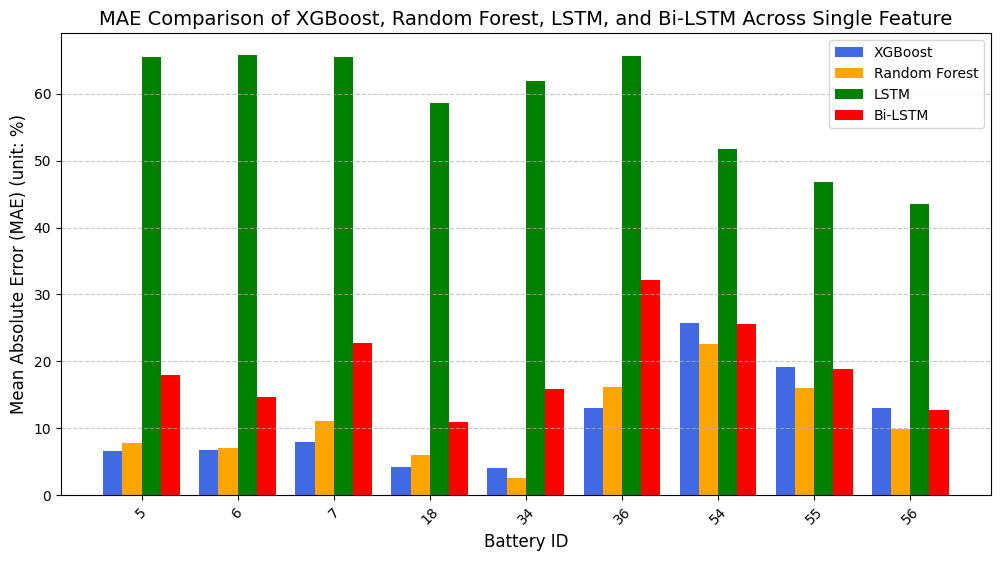

In [ ]:
# Draw graph to compare MAE between 4 models using single feature

battery_id_draw = [5, 6, 7, 18, 34, 36, 54, 55, 56]

# Sort battery IDs for consistent ordering
sorted_batteries = sorted(battery_id_draw)

# Extract MAE values for each model (use NaN for missing values)
xgb_mae_values = [single_mae_xgb_per_battery.get(b, np.nan) * 100 for b in sorted_batteries]
rf_mae_values = [single_mae_rf_per_battery.get(b, np.nan) * 100 for b in sorted_batteries]
lstm_mae_values = [single_mae_lstm_per_battery.get(b, np.nan) * 100 for b in sorted_batteries]
bi_lstm_mae_values = [single_mae_bi_lstm_per_battery.get(b, np.nan) * 100 for b in sorted_batteries]

# Set up bar width
bar_width = 0.2
x = np.arange(len(sorted_batteries))

# Create the bar plot
plt.figure(figsize=(12, 6))
plt.bar(x - 1.5 * bar_width, xgb_mae_values, bar_width, label="XGBoost", color="royalblue")
plt.bar(x - 0.5 * bar_width, rf_mae_values, bar_width, label="Random Forest", color="orange")
plt.bar(x + 0.5 * bar_width, lstm_mae_values, bar_width, label="LSTM", color="green")
plt.bar(x + 1.5 * bar_width, bi_lstm_mae_values, bar_width, label="Bi-LSTM", color="red")

# Labels and Titles
plt.xlabel("Battery ID", fontsize=12)
plt.ylabel("Mean Absolute Error (MAE) (unit: %)", fontsize=12)
plt.title("MAE Comparison of XGBoost, Random Forest, LSTM, and Bi-LSTM Across Single Feature", fontsize=14)
plt.xticks(ticks=x, labels=sorted_batteries, rotation=45)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()

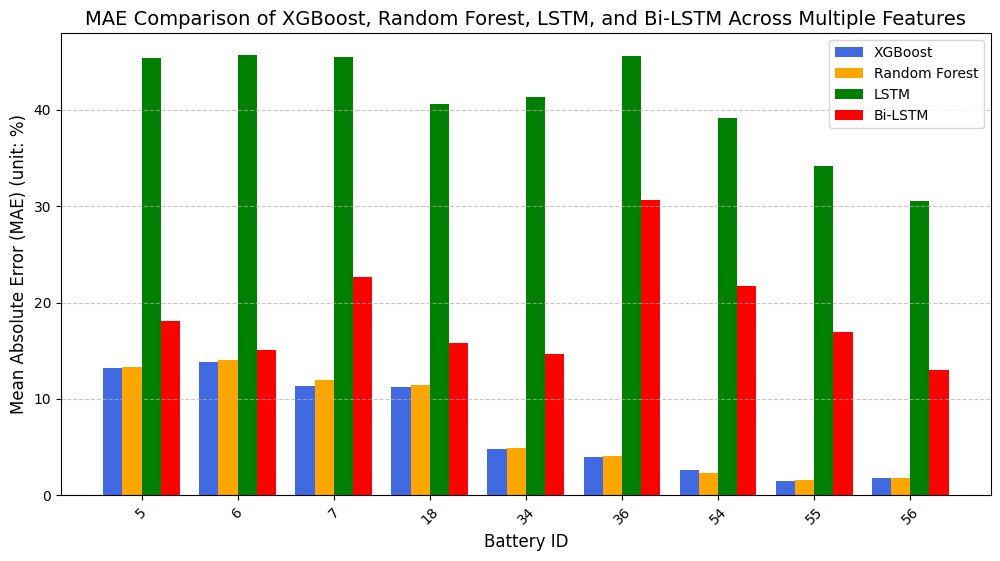

In [ ]:
# Draw graph to compare MAE between 4 models using multiple features

battery_id_draw = [5, 6, 7, 18, 34, 36, 54, 55, 56]

# Sort battery IDs for consistent ordering
sorted_batteries = sorted(battery_id_draw)

# Extract MAE values for each model (use NaN for missing values)
xgb_mae_values = [multi_mae_xgb_per_battery.get(b, np.nan) * 100 for b in sorted_batteries]
rf_mae_values = [multi_mae_rf_per_battery.get(b, np.nan) * 100 for b in sorted_batteries]
lstm_mae_values = [multi_mae_lstm_per_battery.get(b, np.nan) * 100 for b in sorted_batteries]
bi_lstm_mae_values = [multi_mae_bi_lstm_per_battery.get(b, np.nan) * 100 for b in sorted_batteries]

# Set up bar width
bar_width = 0.2
x = np.arange(len(sorted_batteries))

# Create the bar plot
plt.figure(figsize=(12, 6))
plt.bar(x - 1.5 * bar_width, xgb_mae_values, bar_width, label="XGBoost", color="royalblue")
plt.bar(x - 0.5 * bar_width, rf_mae_values, bar_width, label="Random Forest", color="orange")
plt.bar(x + 0.5 * bar_width, lstm_mae_values, bar_width, label="LSTM", color="green")
plt.bar(x + 1.5 * bar_width, bi_lstm_mae_values, bar_width, label="Bi-LSTM", color="red")

# Labels and Titles
plt.xlabel("Battery ID", fontsize=12)
plt.ylabel("Mean Absolute Error (MAE) (unit: %)", fontsize=12)
plt.title("MAE Comparison of XGBoost, Random Forest, LSTM, and Bi-LSTM Across Multiple Features", fontsize=14)
plt.xticks(ticks=x, labels=sorted_batteries, rotation=45)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()